#Email Phishing Detection


##Imports

In [ ]:
import itertools
import time
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler

from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('stopwords')

from IPython.display import Image

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##Load Dataset



In [ ]:
data_df = pd.read_csv('fraud_email_.csv')

In [ ]:
data_df = data_df.dropna()

data_df['Text'] = data_df['Text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data_df['Text'] = data_df['Text'].str.replace('[^\w\s]','')

stop = stopwords.words('english')
data_df['Text'] = data_df['Text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

from sklearn.feature_extraction.text import TfidfVectorizer
corpus = data_df['Text']
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)

print(X.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


(11928, 130424)


In [ ]:
data_df = data_df.dropna()

stopset = set(stopwords.words("english"))
vectorizer = TfidfVectorizer(stop_words = stopset, norm='l2', decode_error='ignore',binary=True)
features = vectorizer.fit_transform(data_df["Text"])

print(features.shape[:])
y = data_df["Class"]

train_X, test_X, train_y, test_y = train_test_split(X, data_df["Class"], test_size=0.5, stratify=data_df["Class"])

(11928, 130424)


##Exploratory Data Analysis

In [ ]:
data_df.head()

,Text,Class
0,supply quality chinas exclusive dimensions unb...,1
1,sidlet know thx,0
2,dear friendgreetings youi wish accost request ...,1
3,mr cheung puihang seng bank ltddes voeux rd br...,1
4,surprising assessment embassy,0


In [ ]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11928 entries, 0 to 11928
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    11928 non-null  object
 1   Class   11928 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 279.6+ KB


In [ ]:
data_df.describe()

,Class
count,11928.000000
mean,0.434775
std,0.495748
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


##Decision Tree

In [ ]:
max_depth = 15

tree_auc_train, tree_auc_test = np.zeros(max_depth), np.zeros(max_depth)

for i in range(1,max_depth):
    clf_decision_tree = tree.DecisionTreeClassifier(max_depth=i, criterion='entropy',random_state=1)
    clf_decision_tree = clf_decision_tree.fit(train_X, train_y)

    tree_auc_train[i] = roc_auc_score(train_y, clf_decision_tree.predict_proba(train_X)[:,1])
    tree_auc_test[i] = roc_auc_score(test_y, clf_decision_tree.predict_proba(test_X)[:,1])

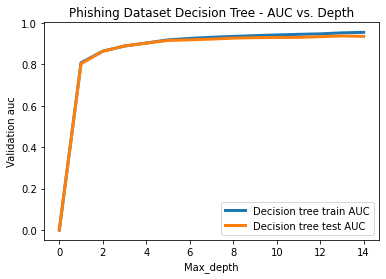

<Figure size 720x720 with 0 Axes>

In [ ]:
from matplotlib import pyplot
pyplot.plot(tree_auc_train, linewidth=3, label = "Decision tree train AUC")
pyplot.plot(tree_auc_test, linewidth=3, label = "Decision tree test AUC")
pyplot.legend()

pyplot.title("Phishing Dataset Decision Tree - AUC vs. Depth")
pyplot.xlabel("Max_depth")
pyplot.ylabel("Validation auc")
pyplot.show()

In [ ]:
print("Best tree depth training: " + str(np.argmax(tree_auc_train, axis=0)))
print("Highest AUC score training: " + str(np.max(tree_auc_train, axis=0)))
print("Best tree depth testing: " + str(np.argmax(tree_auc_test, axis=0)))
print("Highest AUC score testing: " +  str(np.max(tree_auc_test, axis=0)))

Best tree depth training: 14
Highest AUC score training: 0.954856382042198
Best tree depth testing: 13
Highest AUC score testing: 0.9374528872716325


##Decision Tree with Pruning

In [ ]:
from sklearn.tree._tree import TREE_LEAF

def is_leaf(inner_tree, index):

    return (inner_tree.children_left[index] == TREE_LEAF and 
            inner_tree.children_right[index] == TREE_LEAF)

def prune_index(inner_tree, decisions, index=0):
    # Start pruning from the bottom 
    if not is_leaf(inner_tree, inner_tree.children_left[index]):
        prune_index(inner_tree, decisions, inner_tree.children_left[index])
    if not is_leaf(inner_tree, inner_tree.children_right[index]):
        prune_index(inner_tree, decisions, inner_tree.children_right[index])

    # Prune children if both are leaves     
    if (is_leaf(inner_tree, inner_tree.children_left[index]) and
        is_leaf(inner_tree, inner_tree.children_right[index]) and
        (decisions[index] == decisions[inner_tree.children_left[index]]) and 
        (decisions[index] == decisions[inner_tree.children_right[index]])):
        # turn node into a leaf 
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
        print("Pruned {}".format(index))

def prune_duplicate_leaves(mdl):

    decisions = mdl.tree_.value.argmax(axis=2).flatten().tolist() # Decision for each node
    prune_index(mdl.tree_, decisions)



In [ ]:
clf_decision_tree = tree.DecisionTreeClassifier(max_depth=i, criterion='entropy',random_state=1)
clf_decision_tree = clf_decision_tree.fit(train_X, train_y)
prune_duplicate_leaves(clf_decision_tree)
    
tree_auc_train_pruned = roc_auc_score(train_y, clf_decision_tree.predict_proba(train_X)[:,1])
tree_auc_test_pruned = roc_auc_score(test_y, clf_decision_tree.predict_proba(test_X)[:,1])

print("pruned decision tree training: " + str(tree_auc_train_pruned))
print("pruned decision tree testing: " + str(tree_auc_test_pruned))

Pruned 18
Pruned 17
Pruned 16
pruned decision tree training: 0.9588968222525494
pruned decision tree testing: 0.9394205104379898


In [ ]:
from sklearn.model_selection import learning_curve


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
 
    plt.legend(loc="best")
    return plt


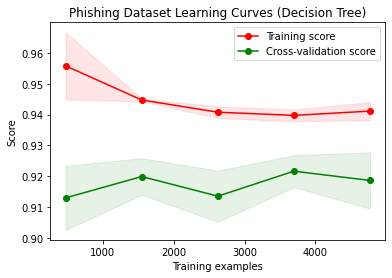

In [ ]:
X, y = train_X, train_y

title = "Phishing Dataset Learning Curves (Decision Tree)"
estimator = tree.DecisionTreeClassifier(max_depth=9, criterion='entropy',random_state=1)
plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=-1)

plt.show()

##Decision Tree with Boosting

In [ ]:
max_depth = 15

adaboost_auc_train, adaboost_auc_test = np.zeros(max_depth), np.zeros(max_depth)

for i in range(1,max_depth):
    clf_adaboost = AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(max_depth=i,criterion='entropy'), n_estimators=10, random_state=1)
    clf_adaboost = clf_adaboost.fit(train_X, train_y)

    adaboost_auc_train[i] = roc_auc_score(train_y, clf_adaboost.predict_proba(train_X)[:,1])
    adaboost_auc_test[i] = roc_auc_score(test_y, clf_adaboost.predict_proba(test_X)[:,1])

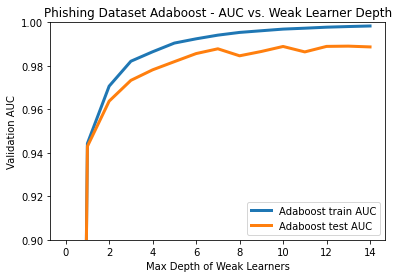

<Figure size 1152x576 with 0 Axes>

In [ ]:
pyplot.plot(adaboost_auc_train, linewidth=3, label = "Adaboost train AUC")
pyplot.plot(adaboost_auc_test, linewidth=3, label = "Adaboost test AUC")
pyplot.legend()
pyplot.ylim(0.9, 1.0)
pyplot.xlabel("Max Depth of Weak Learners")
pyplot.ylabel("Validation AUC")
plt.title("Phishing Dataset Adaboost - AUC vs. Weak Learner Depth")
pyplot.figure(figsize=(16,8))
pyplot.savefig('Phishing_boosting_fig4')
pyplot.show()

In [ ]:
print("Best weak learner tree depth training: " + str(np.argmax(adaboost_auc_train, axis=0)))
print("Highest AUC score training: " + str(np.max(adaboost_auc_train, axis=0)))
print("Best weak learner tree depth testing: " + str(np.argmax(adaboost_auc_test, axis=0)))
print("Highest AUC score testing: " +  str(np.max(adaboost_auc_test, axis=0)))

Best weak learner tree depth training: 14
Highest AUC score training: 0.9983333720397991
Best weak learner tree depth testing: 13
Highest AUC score testing: 0.9890661861115938


In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
 
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

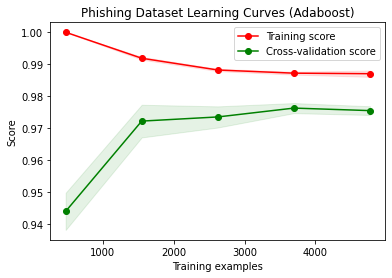

In [ ]:
title = "Phishing Dataset Learning Curves (Adaboost)"
estimator = AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(max_depth=4,criterion='entropy', random_state=1), n_estimators=10,random_state=1)
plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=-1)

plt.show()

##K-Nearest Neighbours

In [ ]:
max_k = 20
knn_auc_train, knn_auc_test = np.zeros(max_k), np.zeros(max_k)
training_time, prediction_time = np.zeros(max_k), np.zeros(max_k)
for i in range(1,max_k):
    clf_knn = KNeighborsClassifier(n_neighbors=i, algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, p=2, weights='uniform')
    
    clf_knn = clf_knn.fit(train_X, train_y)

    pred_train = clf_knn.predict_proba(train_X)[:,1]
    pred_test = clf_knn.predict_proba(test_X)[:,1]

    knn_auc_train[i] = roc_auc_score(train_y, pred_train)
    knn_auc_test[i] = roc_auc_score(test_y, pred_test)

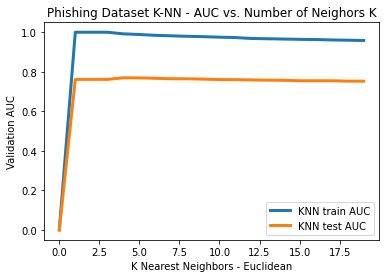

In [ ]:
pyplot.plot(knn_auc_train, linewidth=3, label = "KNN train AUC")
pyplot.plot(knn_auc_test, linewidth=3, label = "KNN test AUC")
pyplot.legend()
pyplot.xlabel("K Nearest Neighbors - Euclidean")
pyplot.ylabel("Validation AUC")
pyplot.title("Phishing Dataset K-NN - AUC vs. Number of Neighors K")
pyplot.show()

In [ ]:
print("Best number of neighbors training: " + str(np.argmax(knn_auc_train, axis=0)))
print("Highest AUC score training: " + str(np.max(knn_auc_train, axis=0)))
print("Best number of neighbors testing: " + str(np.argmax(knn_auc_test, axis=0)))
print("Highest AUC score testing: " +  str(np.max(knn_auc_test, axis=0)))

Best number of neighbors training: 1
Highest AUC score training: 0.9998071731585036
Best number of neighbors testing: 4
Highest AUC score testing: 0.7694433922514383


In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, "o-", 
                     alpha=0.1, 
                     color="r", 
                     )
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, "o-",
                     test_scores_mean + test_scores_std,alpha=0.1, color="g", 
                     )
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt
  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: The parameter where must have the same size as x in fill_between(). This will become an error in future versions of Matplotlib.


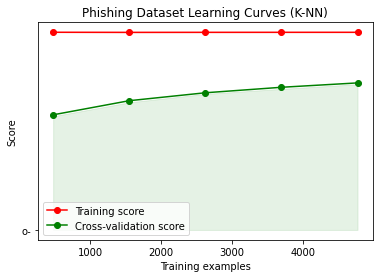

In [ ]:
title = "Phishing Dataset Learning Curves (K-NN)"
estimator = KNeighborsClassifier(n_neighbors=1, algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, p=2, weights='uniform')
plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=-1)
plt.show()

##Support Vector Machine

In [ ]:
clf_svm_linear = SVC(kernel='linear',probability=True, random_state=1)

clf_svm_linear.fit(train_X, train_y)

pred_train_linear = clf_svm_linear.predict_proba(train_X)[:,1]
pred_test_linear = clf_svm_linear.predict_proba(test_X)[:,1]

svm_auc_train_linear = roc_auc_score(train_y, pred_train_linear)
svm_auc_test_linear = roc_auc_score(test_y, pred_test_linear)

clf_svm_rbf = SVC(kernel='poly',probability=True, random_state=1)

clf_svm_rbf.fit(train_X, train_y)

pred_train_rbf = clf_svm_rbf.predict_proba(train_X)[:,1]
pred_test_rbf = clf_svm_rbf.predict_proba(test_X)[:,1]

svm_auc_train_rbf = roc_auc_score(train_y, pred_train_rbf)
svm_auc_test_rbf = roc_auc_score(test_y, pred_test_rbf)

In [ ]:
print("Linear kernel training AUC: " + str(svm_auc_train_linear))
print("Linear kernel testing AUC: " + str(svm_auc_test_linear))
print("Poly kernel training AUC: " + str(svm_auc_train_rbf))
print("Poly kernel testing AUC: " + str(svm_auc_test_rbf))

Linear kernel training AUC: 0.9999954810677905
Linear kernel testing AUC: 0.9975125852262035
Poly kernel training AUC: 0.9999966251012613
Poly kernel testing AUC: 0.997921634393673


In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)


    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

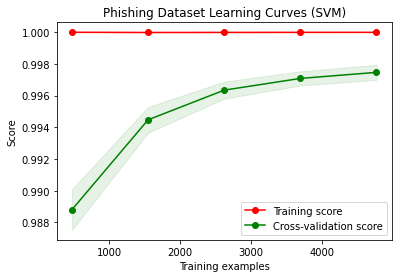

In [ ]:
title = "Phishing Dataset Learning Curves (SVM)"
estimator = SVC(kernel='linear',probability=True, random_state=1)
plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=-1)

plt.show()